<a href="https://colab.research.google.com/github/rafaelfcardoso/naive-bayes-trading-system/blob/main/PETR4_Multinomial_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bt

In [ ]:
!pip install yfinance
!pip install --upgrade mplfinance
 
#Instalação da Biblioteca TA-lib
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install pandas_ta

In [22]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf

import talib as ta
#import pandas_ta as pd_ta

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

In [23]:
%matplotlib inline

In [24]:
stock_ticker = 'PETR4.SA'
start_date = '2016-01-25'
end_date = '2020-05-27'

yf_stock = yf.Ticker(stock_ticker)
df_stock = yf_stock.history(start=start_date, end=end_date)

stock_ticker = '^BVSP'
yf_ibov = yf.Ticker(stock_ticker)
df_ibov = yf_ibov.history(start=start_date, end=end_date)

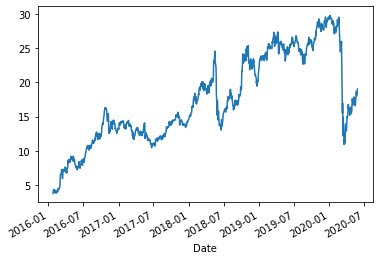

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-26,3.796411,3.868210,3.697686,3.769486,71933300,0.0,0
2016-01-27,3.787435,4.164384,3.733586,4.101560,79437900,0.0,0
2016-01-28,4.191310,4.604158,3.904111,4.128485,131960900,0.0,0
2016-01-29,4.218234,4.361834,4.056685,4.343884,93013900,0.0,0
2016-02-01,4.254133,4.361833,4.182333,4.236183,51910300,0.0,0


In [25]:
df_stock['Close'].plot()
plt.show()
df_stock.head()

In [26]:
def indicadores(stock_data):
    #Retorna as features para o treinamento do modelo

    data = stock_data.copy()
    #Valores do indicador Williams %R:
    data['W%R'] = ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)

     #Valores do indicador MACD:
    data['MACD'], data['Signal-line'], data['Histograma_MACD'] = ta.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    #Sinal histograma MACD, 1 bulLish, 0 bearish:
    data.loc[:, 'Momento_MACD']=np.where(data['Histograma_MACD']>0, 1, 0) 

    #Tendencia no histograma MACD, 1 bullish, 0 para bearish:
    data['Tendencia_MACD']=np.where(data['Histograma_MACD'].diff()>0, 1, 0) 

    #data.loc[:, 'W%R_Sinal']= np.where(data['W%R']<-90, 2, np.where(data['W%R']>-10,0, 1)) # Retorna 1 para sinal de compra, Williams %R < -80, -1 para sinal de venda, caso Williams %R > -20
    data.loc[:, 'W%R_Compra']= np.where(data['W%R']<-80, 1, 0) # Retorna 1 para sinal de compra, caso Williams %R < -80
    #data.loc[:, 'W%R_Venda']= np.where(data['W%R']>-10, 1, 0)  # Retorna 1 para sinal de venda, caso Williams %R > -20
    
    
    data['Hammer']=ta.CDLHAMMER(data['Open'],data['High'], data['Low'], data['Close'])/100 #Sinal de compra pra martelo.
    data['Shooting_star'] = ta.CDLSHOOTINGSTAR(data['Open'],data['High'], data['Low'], data['Close'])/-100 #Sinal de venda 'estrela cadente'

    #Medias moveis exponenciais:
    data["EMA9"] =  ta.EMA(data["Close"], timeperiod=9)
    data["EMA21"] =  ta.EMA(data["Close"], timeperiod=21)
    data["EMA200"] =  ta.EMA(data["Close"], timeperiod=200)

    data['Tendencia_Primaria'] = np.where(data['EMA200'].diff()>0, 1, 0)
    data['Tendencia_Secundaria'] = np.where(data['EMA21'].diff()>0, 1, 0)
    data['Tendencia_Terciaria'] = np.where(data['EMA9'].diff()>0, 1, 0)


    
    #return data[['W%R_Compra','Tendencia_MACD', 'Tendencia_Primaria', 'Tendencia_Secundaria','Tendencia_Terciaria',"EMA9","EMA21","EMA200",'W%R','MACD','Hammer','Shooting_star','Momento_MACD','Tendencia_MACD','W%R_Sinal',]]
    return data[['W%R_Compra','Momento_MACD']]

                     1d_close_pct  1d_future_close_pct
1d_close_pct             1.000000            -0.087415
1d_future_close_pct     -0.087415             1.000000


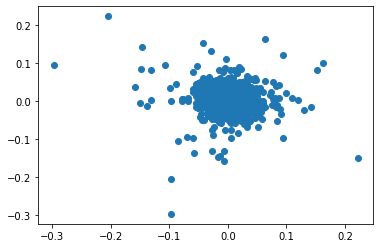

In [27]:
#target 1 dia
df_stock['1d_close_pct']=df_stock['Close'].pct_change(1)
df_stock['1d_future_close']=df_stock['Close'].shift(-1)
df_stock['1d_future_close_pct']=df_stock['1d_future_close'].pct_change(1)
corr=df_stock[['1d_close_pct','1d_future_close_pct']].corr()
print(corr)
plt.scatter(df_stock['1d_close_pct'],df_stock['1d_future_close_pct'])
plt.show()

                     5d_close_pct  5d_future_close_pct
5d_close_pct             1.000000             0.151682
5d_future_close_pct      0.151682             1.000000


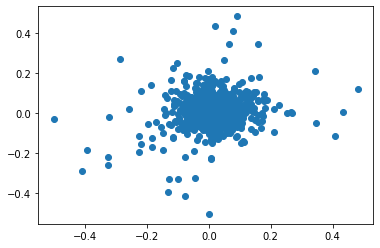

In [28]:
#target 5 dias
df_stock['5d_close_pct']=df_stock['Close'].pct_change(5)
df_stock['5d_future_close']=df_stock['Close'].shift(-5)
df_stock['5d_future_close_pct']=df_stock['5d_future_close'].pct_change(5)
corr=df_stock[['5d_close_pct','5d_future_close_pct']].corr()
print(corr)
plt.scatter(df_stock['5d_close_pct'],df_stock['5d_future_close_pct'])
plt.show()

['W%R_Compra', 'Momento_MACD']
            W%R_Compra  Momento_MACD  5d_future_close_pct  1d_future_close_pct
Date                                                                          
2016-01-26           0             0                  NaN                  NaN
2016-01-27           0             0                  NaN             0.006565
2016-01-28           0             0                  NaN             0.052174
2016-01-29           0             0                  NaN            -0.024794
2016-02-01           0             0                  NaN            -0.088983
2016-02-02           0             0            -0.016279             0.044186
2016-02-03           0             0            -0.008909             0.053452
2016-02-04           0             0            -0.033827            -0.040169
2016-02-05           0             0            -0.022026            -0.050661
2016-02-10           0             0             0.085847            -0.018561
2016-02-11           

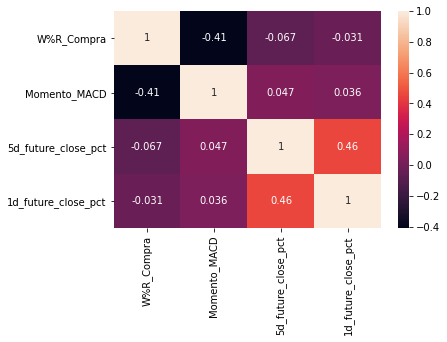

In [29]:
target_5 = df_stock['5d_future_close_pct']
target_1= df_stock['1d_future_close_pct']

#print(target_1, target_5)
features = indicadores(df_stock)
feat_list=features.columns.to_list()
print(feat_list)

#target_bear_trend= features['Tendencia_Terciaria']

df_features_and_target = features
df_features_and_target['5d_future_close_pct']= target_5
df_features_and_target['1d_future_close_pct']= target_1
#print(target_bear_trend.head(20))
print(df_features_and_target.head(20))
corr = df_features_and_target.corr()
sns.heatmap(corr, annot=True)

# Data Cleaning

In [30]:
#Data cleaning
print(df_features_and_target['5d_future_close_pct'].isnull().sum())

indices_5 = df_features_and_target[df_features_and_target['5d_future_close_pct'].isnull()].index
indices_1 = df_features_and_target[df_features_and_target['1d_future_close_pct'].isnull()].index

df_clean_1 = df_features_and_target.drop(indices_1)
df_clean_5 = df_features_and_target.drop(indices_5)

features_clean = df_features_and_target.drop(['5d_future_close_pct', '1d_future_close_pct'], axis=1)
#target_1_clean, target_5_clean = pd.DataFrame(target_1).drop(indices_1), pd.DataFrame(target_5).drop(indices_5)
target_1_clean, target_5_clean = pd.DataFrame(target_1).fillna(value=0), pd.DataFrame(target_5).fillna(value=0)

target_1_clean['Bull'], target_1_clean['Bear'] = np.where(target_1_clean['1d_future_close_pct']>0, 1, 0), np.where(target_1_clean['1d_future_close_pct']<0, 1, 0) 
target_5_clean['Bull'], target_5_clean['Bear'] = np.where(target_5_clean['5d_future_close_pct']>0, 1, 0), np.where(target_5_clean['5d_future_close_pct']<0, 1, 0)


pd.set_option('display.expand_frame_repr', False)
print(target_1_clean)
#print(target_5_clean)
print(features_clean)


5
            1d_future_close_pct  Bull  Bear
Date                                       
2016-01-26             0.000000     0     0
2016-01-27             0.006565     1     0
2016-01-28             0.052174     1     0
2016-01-29            -0.024794     0     1
2016-02-01            -0.088983     0     1
...                         ...   ...   ...
2020-05-20            -0.005699     0     1
2020-05-21            -0.027097     0     1
2020-05-22             0.043385     1     0
2020-05-25             0.009754     1     0
2020-05-26             0.000000     0     0

[1078 rows x 3 columns]
            W%R_Compra  Momento_MACD
Date                                
2016-01-26           0             0
2016-01-27           0             0
2016-01-28           0             0
2016-01-29           0             0
2016-02-01           0             0
...                ...           ...
2020-05-20           0             1
2020-05-21           0             1
2020-05-22           0         

In [31]:
train_size = int(0.5 * target_1_clean.shape[0])
test_size= target_5_clean.shape[0]-train_size
train_features = features_clean[:train_size]
train_targets = target_5_clean['Bull'][:train_size]
#train_targets = target_bear_trend[:train_size]
test_features = features_clean[train_size:]
test_targets = target_5_clean['Bull'][train_size:]
#test_targets = target_bear_trend[train_size:]


In [32]:
print(train_features.columns)
print(target_1_clean.shape[0])
print(train_size)
print(test_size)

Index(['W%R_Compra', 'Momento_MACD'], dtype='object')
1078
539
539


# Multinomial Naive Bayes

In [33]:
def run_model(X,y,model_type):
        
    nb_model = model_type
    result=nb_model.fit(X, y)

    #np.column_stack((y_test.to_list(),nb_model.predict(X_test)))
    #print(nb_model.predict_proba(X_test)[:10])
    #print(f'test_score = {nb_model.score(X_test,y_test)}')
    
    return nb_model

def meas_acc(X,y,nb_model):
    y_pred = nb_model.predict(X)
    print("Number of mislabeled points out of a total %d points : %d" % (X.shape[0], (y != y_pred).sum()))
    print("Mean Test Accuracy: %f"% nb_model.score(X, y))
    cf_train2 = metrics.confusion_matrix(y, y_pred, normalize="all")                                  
    sns.heatmap(cf_train2,linewidths=.5,annot=True,cmap="YlGnBu",cbar=False,square=True,xticklabels=(1,2,3), yticklabels=(1,2,3))
   

Number of mislabeled points out of a total 539 points : 231
Mean Test Accuracy: 0.571429


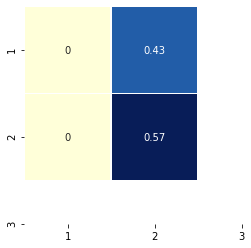

In [34]:
#X_train,X_test,y_train,y_test = train_eval(df_feat_targ_clean,"2016-02-02 00:00:00","2018-01-26 00:00:00")
X_train,X_test,y_train,y_test = train_features, test_features, train_targets, test_targets
mult_nb = run_model(X_train,y_train, MultinomialNB())
#meas_acc(X_train, y_train, mult_nb)
meas_acc(X_test, y_test, mult_nb)

Probability of a successful buy and a successful short after 5 periods: 

In [35]:
probabilities= mult_nb.predict_proba(test_features)
df_proba = pd.DataFrame(probabilities,index=test_features.index)
print(df_proba.head(40))

                   0         1
Date                          
2018-03-19  0.440633  0.559367
2018-03-20  0.391466  0.608534
2018-03-21  0.391466  0.608534
2018-03-22  0.391466  0.608534
2018-03-23  0.391466  0.608534
2018-03-26  0.391466  0.608534
2018-03-27  0.391466  0.608534
2018-03-28  0.440633  0.559367
2018-03-29  0.391466  0.608534
2018-04-02  0.440633  0.559367
2018-04-03  0.440633  0.559367
2018-04-04  0.440633  0.559367
2018-04-05  0.391466  0.608534
2018-04-06  0.391466  0.608534
2018-04-09  0.391466  0.608534
2018-04-10  0.391466  0.608534
2018-04-11  0.391466  0.608534
2018-04-12  0.391466  0.608534
2018-04-13  0.391466  0.608534
2018-04-16  0.391466  0.608534
2018-04-17  0.391466  0.608534
2018-04-18  0.391466  0.608534
2018-04-19  0.378323  0.621677
2018-04-20  0.378323  0.621677
2018-04-23  0.378323  0.621677
2018-04-24  0.378323  0.621677
2018-04-25  0.378323  0.621677
2018-04-26  0.378323  0.621677
2018-04-27  0.378323  0.621677
2018-04-30  0.378323  0.621677
2018-05-